## Neural Network Architecture Search and Aerodynamic Sensitivity Study
            (Submission by SHUBHAM KUMAR - Mat.# 5547548)
                            (Project IV)

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from itertools import combinations
import torch as pt
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Defining constant random state to ensure reproducibility of results
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
pt.manual_seed(RANDOM_STATE)

## Task A : Data Exploratoin and Scaling

In [ ]:
df = pd.read_csv('Project_4.csv')

# ------------- Data exploration and sanity check -----------------------
print('df Shape:', df.shape)                         # size of the dataset
print('Columns:', df.columns.tolist())               # checking for column datav ariables
print('Total missing values, NAs:', df.isna().sum().sum())           # checking for empty data points
print('\n',df.head(5))                               # Preview the first 5 rows of data

df Shape: (11231, 9)
Columns: ['body_id', 'AoA', 'Re', 'Mach', 'max_camber', 'max_thickness', 'nose_bluntness', 'TE_angle', 'Cl']
Total missing values, NAs: 13

       body_id  AoA          Re  Mach  max_camber  max_thickness  \
0  NACA 0006T  0.0  943750.892   0.4    0.000578       0.059598   
1  NACA 0006T  1.0  943750.892   0.4    0.000578       0.059598   
2  NACA 0006T  2.0  943750.892   0.4    0.000578       0.059598   
3  NACA 0006T  3.0  943750.892   0.4    0.000578       0.059598   
4  NACA 0006T  4.0  943750.892   0.4    0.000578       0.059598   

   nose_bluntness  TE_angle        Cl  
0        0.029289  0.797519  0.000000  
1        0.029289  0.797519  0.090346  
2        0.029289  0.797519  0.188297  
3        0.029289  0.797519  0.274029  
4        0.029289  0.797519  0.353611  


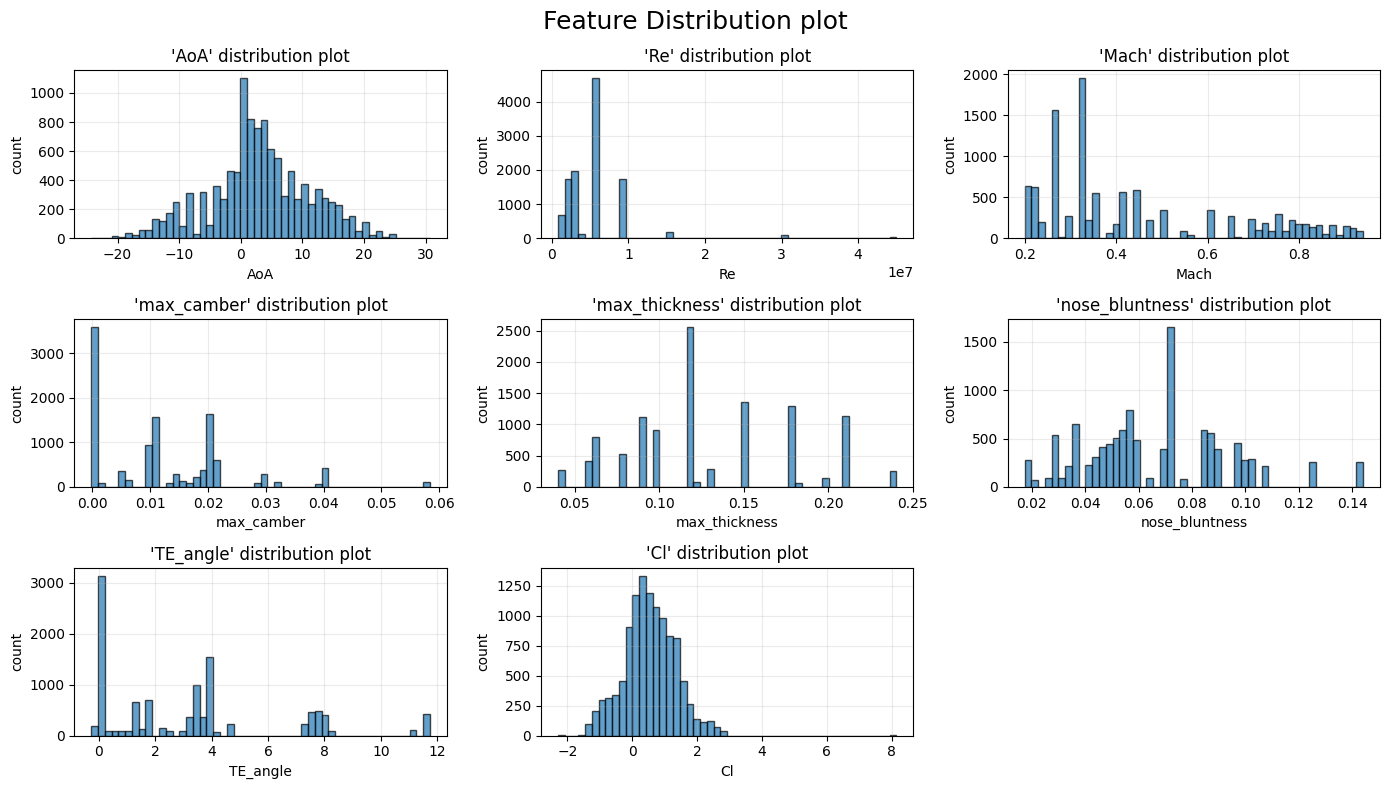

In [ ]:
# --------------------------------------------------------
# TASK A.1 : FEATURE DISTRIBUTION PLOTS
# --------------------------------------------------------

airfoil_list = df.iloc[:, 0].unique()              # shape (98,)
feature_list = df.columns[1:]                      # shape (8,)

def plot_distributions(data, cols):
    """
    Creates a grid of histograms to visualise the statistical distribution
    and the scale of each feature in the dataset.
    """
    fig, ax = plt.subplots(3, 3, figsize=(14, 8))
    ax = ax.flatten()

    # Loop through each feature and generate a histogram
    for i, c in enumerate(cols):
        ax[i].hist(data[c], bins=50, alpha=0.7, edgecolor='black')
        ax[i].set_title(f"'{c}' distribution plot")
        ax[i].set_xlabel(c)
        ax[i].set_ylabel('count')
        ax[i].grid(alpha=0.25)

    ax[-1].set_visible(False)                      # Remove the last empty subplot
    fig.suptitle('Feature Distribution plot', fontsize=18)
    plt.tight_layout()
    # plt.savefig('results_plot/taskA1_distribution.png', dpi=600)

plot_distributions(df, feature_list)

'''
OBSERVATION ;
Below histogram shows how that the feature magnitudes differ by orders of magnitude
(notably Re compared to geometric parameters and Ma), motivating feature scaling
prior to training
''';

Unique Re per family:
 AF_family
other    108
0006      63
0012      36
0009      33
2412      18
2315      15
0008      15
2306      15
2309      15
2409      15
2312      15
2406      15
0015      14
Name: Re, dtype: int64


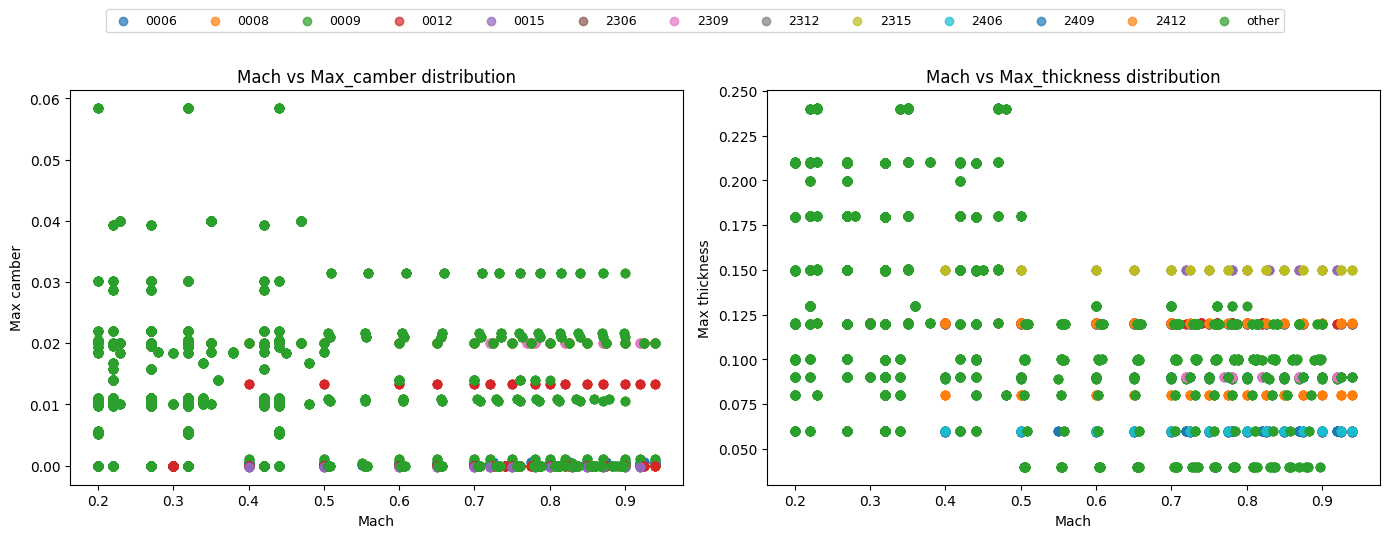


Better Sampling strategy :
The Re-Mach plane shows a clear grid-like structure (experimental matrix)
but large rectangular voids exist, e.g. 0.45 < Mach < 0.6 at mid Re.
A Latin-Hyper-Cube or Sobol sequence would give far better coverage
of the 2-D manifold than the current factorial sweep.



In [ ]:
# --------------------------------------------------------
#        GEOMETRY SCATTER (COLOURED BY FAMILY)
# --------------------------------------------------------

def family(name):                            # adding short name for the airfoil family
    """
    Categorises the 'body_id' string into specific NACA families.
    This helps in grouping similar airfoil shapes for visualisation
    """
    if '0006' in name: return '0006'
    if '0008' in name: return '0008'
    if '0009' in name: return '0009'
    if '0012' in name: return '0012'
    if '0015' in name: return '0015'
    if '2306' in name: return '2306'
    if '2309' in name: return '2309'
    if '2312' in name: return '2312'
    if '2315' in name: return '2315'
    if '2406' in name: return '2406'
    if '2409' in name: return '2409'
    if '2412' in name: return '2412'
    return 'other'

df['AF_family'] = df['body_id'].apply(family)             # adding additional 'AF_family' to df

family_Re_stats = df.groupby('AF_family')['Re'].nunique().sort_values(ascending=False)
print('Unique Re per family:\n', family_Re_stats)         # printing unique Re per fammily


# -----------------------------------------------------------------
#       TASK A.2 PARAMETER SPACE VISUALISATION
# -----------------------------------------------------------------
fig2, ax = plt.subplots(1, 2, figsize=(14, 5))
family_list = df['AF_family'].unique()

# Iterate through each family to plot them with distinct colors/labels
for fam in family_list:
    # filter df for current airfoil family (masking)
    sub = df[df['AF_family'] == fam]

    # left subplot
    ax[0].scatter(sub['Mach'], sub['max_camber'], alpha=0.7, label=fam)
    ax[0].set_title('Mach vs Max_camber distribution')
    ax[0].set_xlabel('Mach'); ax[0].set_ylabel('Max camber')

    # right subplot
    ax[1].scatter(sub['Mach'], sub['max_thickness'], alpha=0.7, label=fam)
    ax[1].set_title('Mach vs Max_thickness distribution')
    ax[1].set_xlabel('Mach'); ax[1].set_ylabel('Max thickness')

handles, labels = ax[0].get_legend_handles_labels()
fig2.legend(handles, labels, loc="upper center", ncol=13, bbox_to_anchor=(0.5, 1.08), fontsize=9)

plt.tight_layout(rect=[0,0,1,0.98])
# plt.savefig('results_plot/taskA2_parameterSpace.png', dpi=600,
#             bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

# ---------------------- COMMENTS ON SAMPLING STRATEGY -----------------------------
comment = textwrap.dedent("""
Better Sampling strategy :
The Re-Mach plane shows a clear grid-like structure (experimental matrix)
but large rectangular voids exist, e.g. 0.45 < Mach < 0.6 at mid Re.
A Latin-Hyper-Cube or Sobol sequence would give far better coverage
of the 2-D manifold than the current factorial sweep.
""")
print(comment)

In [ ]:
# --------------------------------------------------------
#           DATA CLEANING

target_col = "Cl"
df_clean = df.dropna(subset=[target_col]).copy()

print("Original df:", df.shape)
print("Clean df (after NaN drop):", df_clean.shape)

# --------------------------------------------------------
#          TASK A.3 : SELECT AIRFOIL FAMILIES
# --------------------------------------------------------
# For each airfoil, select MULTIPLE (Re, Mach) pairs
# We pick 3 Reynolds numbers per family, which will be hidden from the training process
pick2AF = ['2306', '0009']
testA_conditions = []
N_RE_TESTA = 3

for fam in pick2AF:
    # Filter for the current family (masking)
    sub = df_clean[df_clean['AF_family'] == fam]

    # Identify unique (Re, Mach) combos and sort by Re
    re_mach_pairs = (sub[['Re', 'Mach']].drop_duplicates().sort_values('Re').reset_index(drop=True))

    # Select evenly spaced Reynolds numbers
    selected_idx = np.linspace(0, len(re_mach_pairs) - 1, N_RE_TESTA, dtype=int)
    selected_pairs = re_mach_pairs.iloc[selected_idx]

    # storing these to create "Test-A" set
    for _, row in selected_pairs.iterrows():
        testA_conditions.append((fam, row['Re'], row['Mach']))

    # print(f"\n{fam} – Test-A (Re, Mach) pairs:")
    # print(selected_pairs)

# --------------------------------------------------------
#          Build Test-A mask on the CLEANED df
# --------------------------------------------------------
# We mark rows as 'True' if they belong to the specific (Airfoil, Re, Mach) combinations we just picked.
# This removes ENTIRE AoA sweeps for selected (AF, Re, Mach) from the training set
mask_testA = np.zeros(len(df_clean), dtype=bool)

for fam, re, mach in testA_conditions:
    mask_testA |= (
        (df_clean['AF_family'] == fam) &
        (df_clean['Re'] == re) &
        (df_clean['Mach'] == mach)
    )

testA_df = df_clean[mask_testA].copy()
rest_df  = df_clean[~mask_testA].copy()
print('Test-A size:', testA_df.shape)

# -----------------------------------------------------------------
# Random train-test split (80/20) on remaining data --> Test-B

train_df, testB_df = train_test_split(rest_df, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

print('Train size:', train_df.shape)
print('Test-B size:', testB_df.shape)

comment = textwrap.dedent('''
COMMENTS FOR TWO TEST SETS :
- Test Set A : Evaluates "physical generalisation", by removing entire AoA sweeps,
  we test if the model can predict the aerodynamic behaviour of a specific flight
  conditions it has never seen before.
- Test Set B : Evaluates "statistical generalisation". It test the model's performance
  on remaining data split randomly into 'training' and 'Test Set B'.
''')
print(comment)

Original df: (11231, 10)
Clean df (after NaN drop): (11218, 10)
Test-A size: (58, 10)
Train size: (8928, 10)
Test-B size: (2232, 10)

COMMENTS FOR TWO TEST SETS :
- Test Set A : Evaluates "physical generalisation", by removing entire AoA sweeps,
  we test if the model can predict the aerodynamic behaviour of a specific flight
  conditions it has never seen before.
- Test Set B : Evaluates "statistical generalisation". It test the model's performance
  on remaining data split randomly into 'training' and 'Test Set B'.



In [ ]:
# -----------------------------------------------------------------------
#       DEFINE SCALING STRATEGY (physics + statistics aware)
# Rationale:
# - Reynolds number: spans orders of magnitude --> RobustScaler
# - Mach number: bounded, narrow range         --> StandardScaler
# - Angle of attack: approximately symmetric   --> StandardScaler
# - Geometry parameters: bounded               --> StandardScaler

feature_col = ["AoA", "Re", "Mach", "max_camber", "max_thickness", "nose_bluntness", "TE_angle"]
target_col = "Cl"

robust_features = ["Re"]
standard_features = [c for c in feature_col if c not in robust_features]
print(f'Robust scaled Features : {robust_features}')
print(f'Standard scaled Features : {standard_features}')

# -------------------------------------------------------
#         Fit scalers on TRAINING data only
# This prevents "Data Leakage," ensuring the model has no knowledge of the
# distribution of the test sets during the training phase.

scalers = {}

scalers['robust'] = RobustScaler()
scalers['robust'].fit(train_df[robust_features])

scalers['standard'] = StandardScaler()
scalers['standard'].fit(train_df[standard_features])

# --------------------------------------------------------
#        TASK A.4 ; Scaling function (reusable)
# --------------------------------------------------------
def apply_scaling(df_type, scalers):
    """
    Applies the pre-fitted scaling transformations to a given dataframe.
    This ensures that Training, Test-A, and Test-B are all transformed
    using the exact same parameters.
    """

    df_scaled = df_type.copy()

    # Apply Robust Transformation: (x - median) / IQR
    if 'robust' in scalers:
        df_scaled[robust_features] = scalers['robust'].transform(df_scaled[robust_features])

    # Apply Standard Transformation: (x - mean) / std
    if 'standard' in scalers:
        df_scaled[standard_features] = scalers['standard'].transform(df_scaled[standard_features])

    return df_scaled

# --------------------------------------------------------
#       Apply scaling consistently

train_df_scaled = apply_scaling(train_df, scalers)
testB_df_scaled = apply_scaling(testB_df, scalers)
testA_df_scaled = apply_scaling(testA_df, scalers)


Robust scaled Features : ['Re']
Standard scaled Features : ['AoA', 'Mach', 'max_camber', 'max_thickness', 'nose_bluntness', 'TE_angle']


## Task B : Standard Naive MLP and Manual Hyperparameter Search

In [ ]:
feature_cols = feature_col         # from your Task A
target = target_col                # "Cl"

# ------------------------------------------------------------
#       Train/Val split (10% of TRAINING set only)
# we split the scaled training data into "training" and "validation" set, to monitor performance
train_part_df, val_df = train_test_split(train_df_scaled, test_size=0.10,
                                         random_state=RANDOM_STATE, shuffle=True)

# Convert to numpy arrays
X_train = train_part_df[feature_cols].to_numpy(dtype=np.float64)
y_train = train_part_df[target].to_numpy(dtype=np.float64).reshape(-1, 1)

X_val = val_df[feature_cols].to_numpy(dtype=np.float64)
y_val = val_df[target].to_numpy(dtype=np.float64).reshape(-1, 1)

X_testB = testB_df_scaled[feature_cols].to_numpy(dtype=np.float64)
y_testB = testB_df_scaled[target].to_numpy(dtype=np.float64).reshape(-1, 1)

# -------------------------------------------------------
#          PyTorch DataLoaders
# pairs the input features with their labels
# shuffle = True (train only) --> randomises the order of data every epoch
#                             --> to prevent the model from learning the sequence of the csv file
# shuffle = False (Val/Test) --> not needed, as we only want to evaluate performance

batch_size = 64              # 128

train_loader = DataLoader(TensorDataset(pt.tensor(X_train), pt.tensor(y_train)),
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(pt.tensor(X_val), pt.tensor(y_val)),
                        batch_size=batch_size, shuffle=False)
testB_loader = DataLoader(TensorDataset(pt.tensor(X_testB), pt.tensor(y_testB)),
                          batch_size=batch_size, shuffle=False)



In [ ]:
# -------------------------------------------------------
#          TASK B.1 : Model definition (MLP ARCHITECTURE)

pt.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
pt.set_default_dtype(pt.float64)

class MLP(nn.Module):
    """
    A flexible Multi-Layer Perceptron (MLP) class.
    Allows for programmatic control over the depth and width of the network
    to facilitate automated architecture search.
    """
    def __init__(self, n_in: int, n_hidden_layers: int, n_neurons: int):
        """
        n_layers = number of hidden layers (>=2 in this task)
        Each hidden layer has n_neurons and ReLU activation.
        Output is 1 neuron for regression.
        """
        super().__init__()
        layers = []
        layers.append(nn.Linear(n_in, n_neurons))
        layers.append(nn.ReLU())

        for _ in range(n_hidden_layers - 1):            # add (n_hidden_layers - 1) more hidden layers
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(n_neurons, 1))          # regression output
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ---------------------------------------------------
#      Training/eval loop

def train_one_epoch(model, loader, optimizer, criterion):
    """
    Performs one full pass through the training dataset.
    """
    model.train()                           # set model to training mode
    losses = []
    for xb, yb in loader:
        optimizer.zero_grad()           # Reset gradients from the previous batch
        pred = model(xb)                # Forward pass: compute predictions
        loss = criterion(pred, yb)      # Compute MSE

        # Stability Check : stop and return inf, if loss is non-finite
        if not pt.isfinite(loss):
            return float("inf")

        loss.backward()                 # Backward pass: compute gradients via chain rule
        '''Gradient Clipping: Prevents "exploding gradients" by capping the norm
        of gradients at 5.0. Critical for deep network stbility'''
        pt.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()                # Update model weights based on gradients
        losses.append(loss.item())
    return float(np.mean(losses))           # Return average loss for this epoch

def eval_mse(model, loader, criterion):
    """
    Calculates the Mean Squared Error on a validation or test dataset.
    """
    model.eval()
    losses = []
    # Disable gradient calculation to save memory and speed up computation
    with pt.no_grad():
        for xb, yb in loader:
          pred = model(xb)
          loss = criterion(pred, yb)
          losses.append(loss.item())
    return float(np.mean(losses))


def train_mlp(n_hidden_layers: int, n_neurons: int, lr: float = 0.001, epochs: int = 400):
    """
    Trains an MLP and returns:
    model, history dict {train_loss, val_loss}, testB_mse
    """
    n_in = X_train.shape[1]

    model = MLP(n_in=n_in, n_hidden_layers=n_hidden_layers, n_neurons=n_neurons)
    criterion = nn.MSELoss()
    optimizer = pt.optim.AdamW(model.parameters(), lr=lr)
    history = {"train_loss": [], "val_loss": []}

    # Training Loop: Iterate for the specified number of epochs
    for ep in range(epochs):
        train_mse = train_one_epoch(model, train_loader, optimizer=optimizer, criterion=criterion)
        val_mse = eval_mse(model, val_loader, criterion=criterion)

        # Record losses to plot learning curves later
        history["train_loss"].append(train_mse)
        history["val_loss"].append(val_mse)

    # Final Test-B MSE (Statistical Generalisation)
    testB_mse = eval_mse(model, testB_loader, criterion=criterion)

    return model, history, testB_mse

Training Standard MLP Naive model ...
Test-B MSE: 1.242922e-01


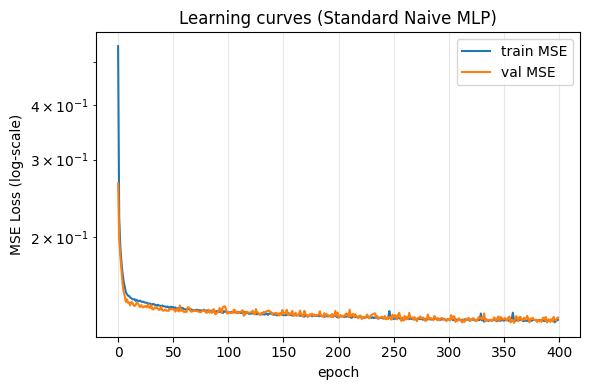

In [ ]:
# -----------------------------------------------
#           Task B.3: Naive architecture
#       2 hidden layers, 16 neurons, ReLU
# -----------------------------------------------

print("Training Standard MLP Naive model ...")

naive_model, naive_hist, naive_testB_mse = train_mlp(n_hidden_layers=2, n_neurons=16, lr=1e-3, epochs=400)
print(f"Test-B MSE: {naive_testB_mse:.6e}")

# Plot learning curves (train + val)
plt.figure(figsize=(6,4))
plt.plot(naive_hist["train_loss"], label="train MSE")
plt.plot(naive_hist["val_loss"], label="val MSE")
plt.yscale("log")
plt.xlabel("epoch") ; plt.ylabel("MSE Loss (log-scale)")
plt.title("Learning curves (Standard Naive MLP)")
plt.grid(alpha=0.3) ; plt.legend() ; plt.tight_layout()
# plt.savefig('results_plot/taskB3.png', dpi=600)
plt.show()


MANUAL HYPER-PARAMETER TUNING
Varying number of neurons : 
  layers=2, neurons= 16 -> Test-B MSE = 1.302303e-01
  layers=2, neurons= 32 -> Test-B MSE = 1.243304e-01
  layers=2, neurons= 64 -> Test-B MSE = 1.255055e-01
  layers=2, neurons=128 -> Test-B MSE = 1.277344e-01

Varying number of layers : 
  layers=2, neurons= 32 -> Test-B MSE = 1.243304e-01
  layers=4, neurons= 32 -> Test-B MSE = 1.271230e-01

Best manual-search model:
  layers=2, neurons=32, Test-B MSE=1.243304e-01


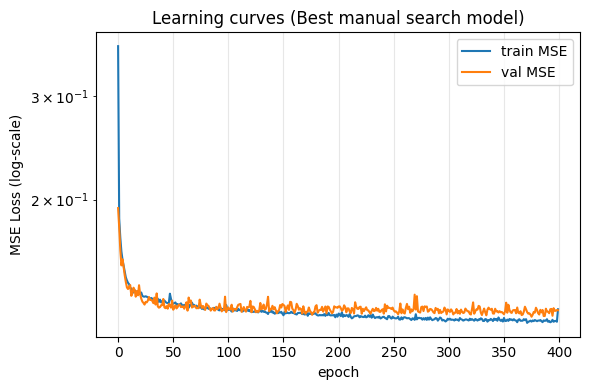

In [ ]:
# ------------------------------------------------------
#        TASK B.5 : MANUAL HYPERPARAMETER SEARCH
# - neurons [16,32,64,128] with layers=2
# - layers [2,4] with neurons=32
# -----------------------------------------------------
print(f"{'='*50}")
print("MANUAL HYPER-PARAMETER TUNING")
print(f"{'='*50}")

def manual_search():
    """
    Executes all  variations over specified architectural parameters.
    Returns a list of all trials and identifies the best-performing model.
    """
    all_trials = []

    # ----------------- (i) Vary neurons ----------------------------
    print("Varying number of neurons : ")
    for n in [16, 32, 64, 128]:
        model, hist, test_mse = train_mlp(n_hidden_layers=2, n_neurons=n, lr=1e-3, epochs=400)
        all_trials.append({"layers": 2, "neurons": n, "lr": 1e-3, "epochs": 400, "testB_mse": test_mse,
                       "history": hist, "model": model})
        print(f"  layers=2, neurons={n:3d} -> Test-B MSE = {test_mse:.6e}")

    # ----------------- (ii) Vary number of layers ---------------------------------
    print("\nVarying number of layers : ")
    for L in [2, 4]:
        if L==2:
            test_mse_2_32 = [t["testB_mse"] for t in all_trials
                             if t["layers"] == 2 and t["neurons"] == 32][0]
            print(f"  layers={L}, neurons= 32 -> Test-B MSE = {test_mse_2_32:.6e}")
        else:
            model, hist, test_mse = train_mlp(n_hidden_layers=L, n_neurons=32, lr=1e-3, epochs=400)
            all_trials.append({"layers": L, "neurons": 32, "lr": 1e-3, "epochs": 400, "testB_mse": test_mse,
                       "history": hist, "model": model})
            print(f"  layers={L}, neurons= 32 -> Test-B MSE = {test_mse:.6e}")

    # -------------- pick best by Test-B MSE ---------------------
    # Identify the configuration with the minimum error on Test-B
    best_trial = min(all_trials, key=lambda d: d["testB_mse"])
    return all_trials, best_trial

all_trials, best_trial = manual_search()

print("\nBest manual-search model:")
print(f"  layers={best_trial['layers']}, neurons={best_trial['neurons']}, Test-B MSE={best_trial['testB_mse']:.6e}")

# Plot learning curve of the best manual search model
plt.figure(figsize=(6,4))
plt.plot(best_trial["history"]["train_loss"], label="train MSE")
plt.plot(best_trial["history"]["val_loss"], label="val MSE")
plt.yscale("log")
plt.xlabel("epoch") ; plt.ylabel("MSE Loss (log-scale)")
plt.title("Learning curves (Best manual search model)")
plt.grid(alpha=0.3) ; plt.legend() ; plt.tight_layout()
# plt.savefig('results_plot/taskB5.png', dpi=600)
plt.show()


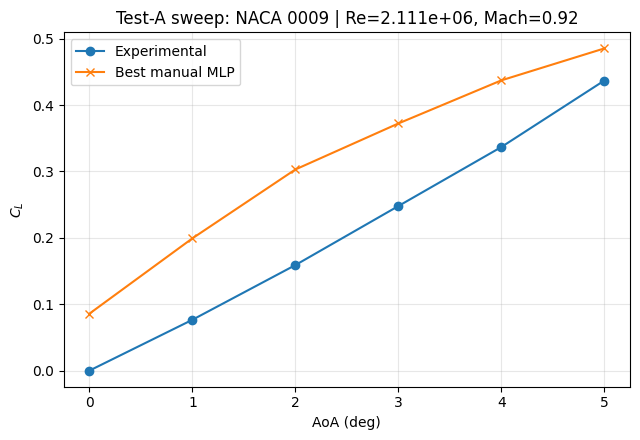

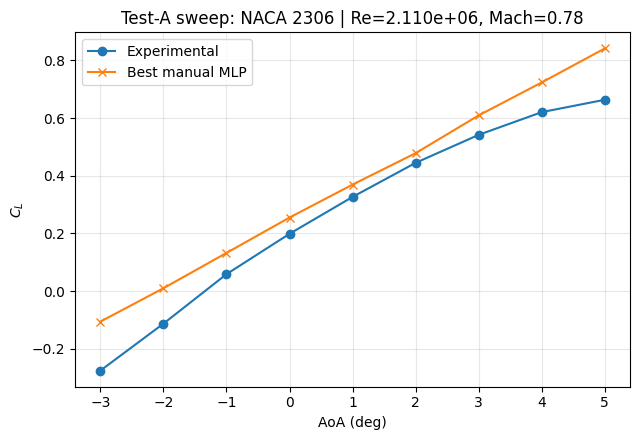

In [ ]:
# -------------------------------------------------------------------
#      TASK B.6 : PLOTTING BEST MANUAL SEARCH MODEL VS EXPERIMENTAL
# -------------------------------------------------------------------
# Objective: Evaluate the best manual model's ability to reconstruct
# full Angle of Attack (AoA) sweeps for conditions never seen during training.

# Ensure alignment
assert (testA_df_scaled.index == testA_df.index).all(), \
    "Index mismatch between scaled and unscaled Test-A dataframes."

testA_plot = testA_df_scaled.copy()

# Physical (unscaled) columns for plotting/labels
testA_plot["AoA_deg"]   = testA_df.loc[testA_plot.index, "AoA"].values
testA_plot["AF_family"] = testA_df.loc[testA_plot.index, "AF_family"].values
testA_plot["Re_phys"]   = testA_df.loc[testA_plot.index, "Re"].values
testA_plot["Mach_phys"] = testA_df.loc[testA_plot.index, "Mach"].values

# Ground truth
testA_plot["Cl_true"] = testA_df.loc[testA_plot.index, "Cl"].values

# --- MODEL INFERENCE --- Predict CL for all Test-A rows -------
best_model = best_trial["model"]
best_model.eval()                                                             # Set model to evaluation mode

X_testA = testA_plot[feature_cols].to_numpy(dtype=np.float64)
X_testA_t = pt.tensor(X_testA, dtype=pt.float64)

with pt.no_grad():                                                            # avoids storing gradients (faster, less memory)
    pred = best_model(X_testA_t).detach().numpy().reshape(-1)                 # pred becomes a 1D numpy array of predicted Cl
testA_plot["Cl_pred"] = pred                                                  # predicted Cl

# Choose 1 Reynolds number per airfoil family in Test-A
# We'll take the middle Re (by sorting unique Re) for each family to be stable.
for fam, fam_df in testA_plot.groupby("AF_family"):
    unique_Re = np.sort(fam_df["Re_phys"].unique())
    Re_pick = unique_Re[len(unique_Re)//2]

    sub = fam_df[fam_df["Re_phys"] == Re_pick]
    Mach_pick = np.sort(sub["Mach_phys"].unique())[0]

    curve = sub[sub["Mach_phys"] == Mach_pick].sort_values("AoA_deg")

    plt.figure(figsize=(6.5, 4.5))
    plt.plot(curve["AoA_deg"], curve["Cl_true"], marker="o", label="Experimental")
    plt.plot(curve["AoA_deg"], curve["Cl_pred"], marker="x", label="Best manual MLP")
    plt.xlabel("AoA (deg)") ; plt.ylabel("$C_L$")
    plt.title(f"Test-A sweep: NACA {fam} | Re={Re_pick:.3e}, Mach={Mach_pick:.2f}")
    plt.grid(alpha=0.3) ; plt.legend() ; plt.tight_layout()
    # plt.savefig(f"results_plot/taskB6_{fam}.png", dpi=600)
    plt.show()

## Task C :  Bayesian Hyperparameter Optimisation

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 7.3 MB/s eta 0:00:00


In [ ]:
import torch.optim as optim
import optuna

# -----------------------------------------------
#    TASK C.1 & C.2 : OPTUNA Objective function
# -----------------------------------------------
def objective(trial: optuna.Trial) -> float:
    """
    Defines the 'blueprint' for optimization trials.
    """
    # --- HYPERPARAMETER SEARCH SPACE ---
    n_hidden_layers  = trial.suggest_int("n_hidden_layers", 2, 6)
    n_neurons = trial.suggest_int("n_neurons", 16, 128)
    lr        = trial.suggest_float("lr", 1e-4, 1e-1, log=True)

    # --- MODEL INITIALIZATION ---
    model = MLP(n_in=len(feature_cols), n_hidden_layers=n_hidden_layers, n_neurons=n_neurons)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # --- TRAINING LOOP WITH PRUNING ---
    epochs = 200
    best_val = float("inf")

    for ep in range(epochs):
        # Train for one epoch and evaluate on the validation set
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss = eval_mse(model, val_loader, criterion)

        # Track best (lowest) validation MSE (objective), during this trial
        if val_loss < best_val:
            best_val = val_loss

        # Report intermediate value (enables Optuna plots + optional pruning)
        trial.report(val_loss, step=ep)

        # Pruning (keeps runtime down)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # The objective is to minimise the best validation value
    return best_val

# ------------------------------------------------------
#    TASK C.3 : RUN study (Bayesian/TPE) for exactly 30 trials
# ------------------------------------------------------
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)  # Bayesian-ish default in Optuna
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=50) # pruning

study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=30)

print("\n" + "="*30)
print("Bayesian Optimisation Search")
print("="*30)
print(f"Minimum Validation MSE achieved: {study.best_value:.6e}")
print(f"Optimal Configuration: {study.best_params}")



[I 2026-02-13 20:54:14,927] A new study created in memory with name: no-name-90bc6c67-92e2-43ee-851b-a98ae39ec1de
[I 2026-02-13 20:56:30,653] Trial 0 finished with value: 0.12853755203968295 and parameters: {'n_hidden_layers': 3, 'n_neurons': 123, 'lr': 0.015702970884055395}. Best is trial 0 with value: 0.12853755203968295.
[I 2026-02-13 20:57:41,658] Trial 1 finished with value: 0.12758822005059467 and parameters: {'n_hidden_layers': 4, 'n_neurons': 33, 'lr': 0.00029375384576328325}. Best is trial 1 with value: 0.12758822005059467.
[I 2026-02-13 20:58:55,178] Trial 2 finished with value: 0.12693036834412227 and parameters: {'n_hidden_layers': 2, 'n_neurons': 113, 'lr': 0.006358358856676255}. Best is trial 2 with value: 0.12693036834412227.
[I 2026-02-13 21:00:08,507] Trial 3 finished with value: 0.13551864295976837 and parameters: {'n_hidden_layers': 5, 'n_neurons': 18, 'lr': 0.0812324508558869}. Best is trial 2 with value: 0.12693036834412227.
[I 2026-02-13 21:01:34,135] Trial 4 fini


Bayesian Optimisation Search
Minimum Validation MSE achieved: 1.265515e-01
Optimal Configuration: {'n_hidden_layers': 4, 'n_neurons': 82, 'lr': 0.000137832374550072}


/tmp/ipython-input-1740384618.py:16: ExperimentalWarning: optuna.visualization.matplotlib._slice.plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study);
/tmp/ipython-input-1740384618.py:21: ExperimentalWarning: optuna.visualization.matplotlib._contour.plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study);
/tmp/ipython-input-1740384618.py:26: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study);
/tmp/ipython-input-1740384618.py:37: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);
/tmp/ipython-input-1740384618.py:43: ExperimentalWarning: optuna.vis

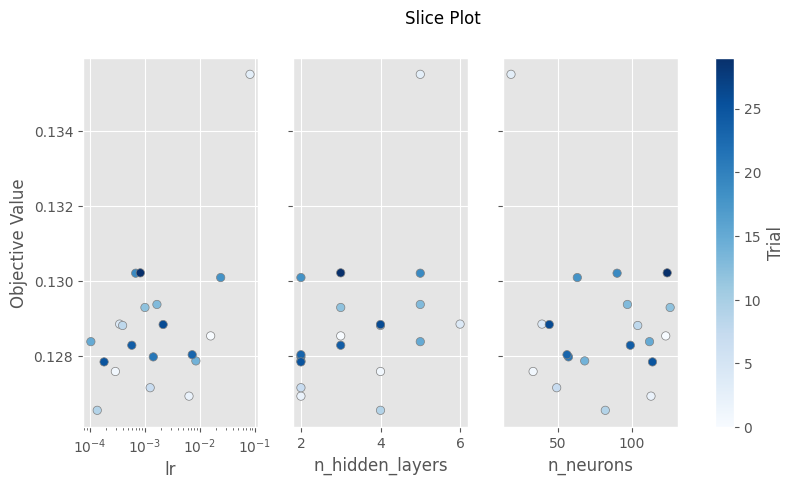

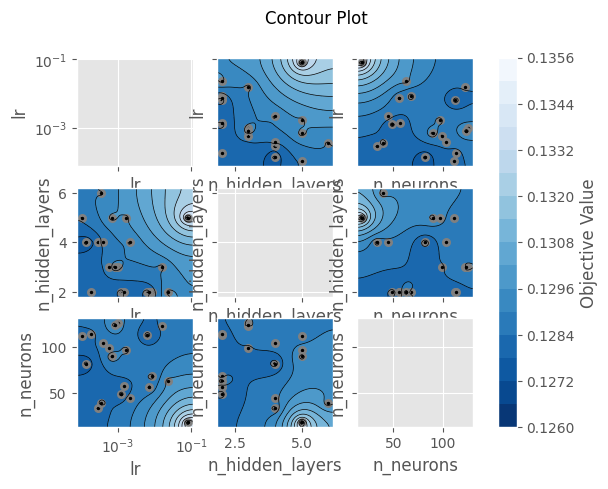

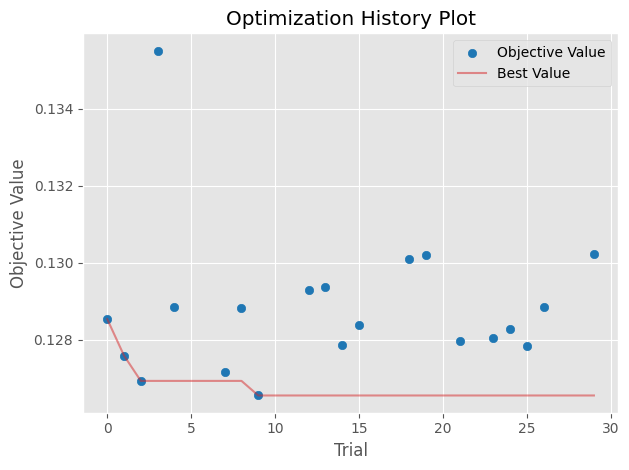

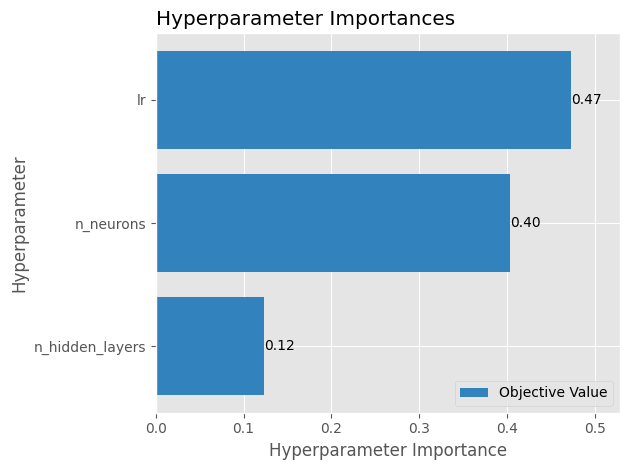

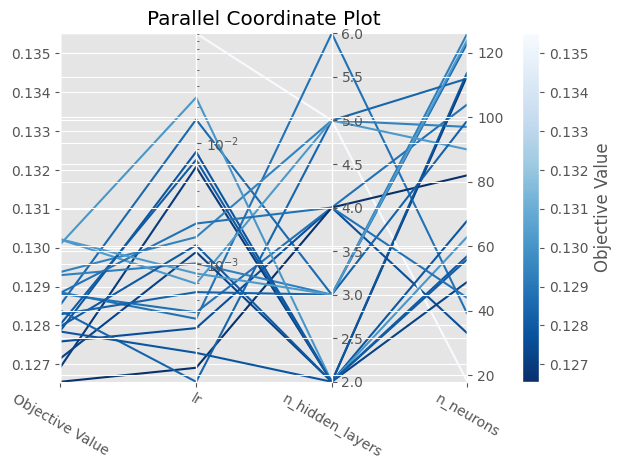

In [ ]:
# ----------------------------------------------
#     TASK C4 & C.5 : VISUALIZING OPTIMISATION SEARCH SPACE
# ---------------------------------------------------
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_slice,
    plot_contour,
    plot_param_importances,
    plot_parallel_coordinate
)

# SLICE PLOT (Hyperparameter vs. Objective)
# Shows the individual influence of each parameter.
# It helps identify if the best results are clustered in specific regions
plot_slice(study);
# plt.savefig("results_plot/taskC5_slice.png",dpi=600, bbox_inches='tight');

# CONTOUR PLOT (Interaction between Parameters)
# Visualises the relationships between pairs of hyperparameters.
plot_contour(study);
# plt.savefig("results_plot/taskC5_contour.png",dpi=600, bbox_inches='tight')

# OPTIMIZATION HISTORY (Convergence Plot)
# Tracks the 'Best Value' over the 30 trials. This confirms whether the search was successful
ax = plot_optimization_history(study);
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor(None)  # Remove external positioning
    legend.set_loc('upper right')    # Place inside upper right
plt.tight_layout() ;
# plt.savefig("results_plot/taskC4_OptmHistory.png",dpi=600, bbox_inches='tight')

# HYPERPARAMETER IMPORTANCE
# One of the most critical plots. It uses a Random Forest evaluator to
# rank which parameter had the most impact on the Cl prediction error.
plot_param_importances(study);
plt.tight_layout() ;
# plt.savefig("results_plot/taskC5_paramImport.png",dpi=600, bbox_inches='tight')

# PARALLEL COORDINATE PLOT
# Visualises the entire high-dimensional search space in one view.
plot_parallel_coordinate(study);
plt.xticks(rotation=10)
plt.tight_layout() ;
# plt.savefig("results_plot/taskC5_parallelCoordinate.png",dpi=600, bbox_inches='tight')


## Task D : Physical Fidelity Audit

Epoch    0/399 | Train 6.702403e-01 | Val 3.408551e-01
Epoch  100/399 | Train 1.257245e-01 | Val 1.305105e-01
Epoch  200/399 | Train 1.221534e-01 | Val 1.296872e-01
Epoch  300/399 | Train 1.196542e-01 | Val 1.301104e-01
Epoch  399/399 | Train 1.180325e-01 | Val 1.336172e-01


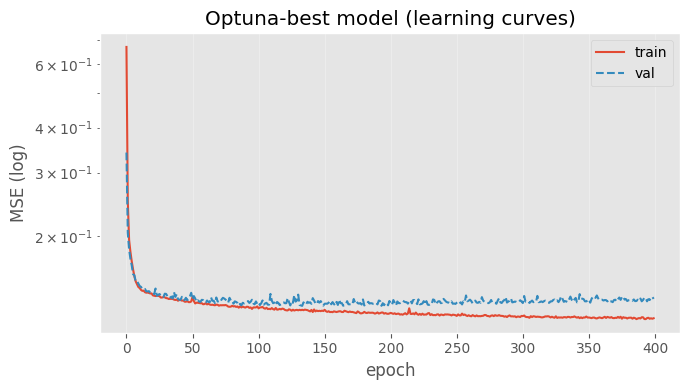

In [ ]:
# -------------------------------------------
# TASK D.1 : RETRAINING OPTUNA-BEST MODEL ON (Task A)
# -------------------------------------------

# EXTRACT OPTIMAL HYPERPARAMETERS ---------------------
# We retrieve the "winning" parameters from the Optuna study object
n_hidden_layers = study.best_params['n_hidden_layers']
n_neurons = study.best_params['n_neurons']
lr = study.best_params['lr']

# MODEL INITIALIZATION ----------------------------
bayes_model = MLP(n_in=len(feature_cols), n_hidden_layers=n_hidden_layers, n_neurons=n_neurons)
criterion = nn.MSELoss()
optimizer = optim.AdamW(bayes_model.parameters(), lr=lr)

epochs = 400
hist = {"train": [], "val": []}

for ep in range(epochs):
    # Perform standard forward-backward pass
    tr = train_one_epoch(bayes_model, train_loader, optimizer=optimizer, criterion=criterion)
    # Evaluate against the validation set to monitor for overfitting
    va = eval_mse(bayes_model, val_loader, criterion=criterion)
    hist["train"].append(tr)
    hist["val"].append(va)

    if ep % 100 == 0 or ep == epochs - 1:
        print(f"Epoch {ep:4d}/{epochs-1} | Train {tr:.6e} | Val {va:.6e}")

# CONVERGENCE visualisation ---------------------------
# plot learning curves (optional but useful)
plt.figure(figsize=(7,4))
plt.plot(hist["train"], label="train")
plt.plot(hist["val"], label="val", linestyle="--")
plt.yscale("log")
plt.xlabel("epoch"); plt.ylabel("MSE (log)")
plt.title("Optuna-best model (learning curves)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
# plt.savefig('results_plot/taskD1.png', dpi=600)
plt.show()


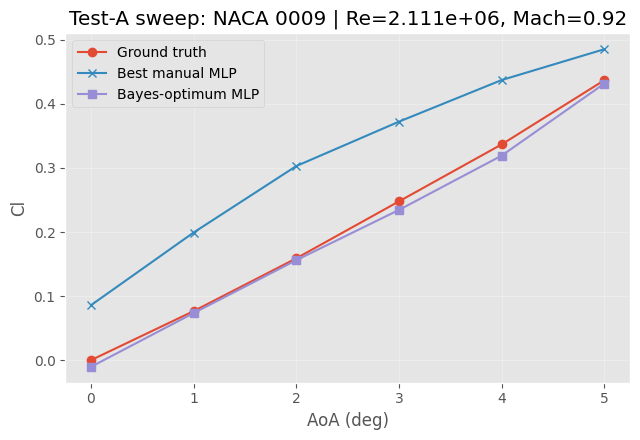

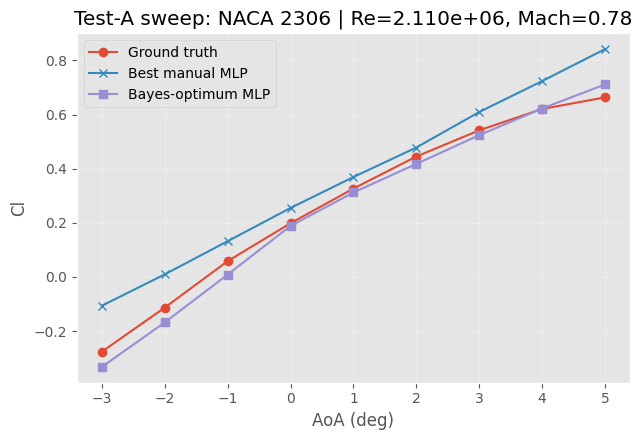

In [18]:
# ----------------------------------------------------
# TASK D.2 : COMPARISON OF MANUAL VS BAYESIAN MODEL
# ----------------------------------------------------

# ensure that the rows in the scaled dataframe align perfectly with the original dataframe
assert (testA_df_scaled.index == testA_df.index).all(), \
    "Index mismatch between scaled and unscaled Test-A dataframes."

# -----------------------------
# Prepare plotting dataframe
testA_plot = testA_df_scaled.copy()

# Add physical (unscaled) quantities for plotting/labels
testA_plot["AoA_deg"]  = testA_df.loc[testA_plot.index, "AoA"].values
testA_plot["AF_family"] = testA_df.loc[testA_plot.index, "AF_family"].values
testA_plot["Re_phys"]   = testA_df.loc[testA_plot.index, "Re"].values
testA_plot["Mach_phys"] = testA_df.loc[testA_plot.index, "Mach"].values

# Ground truth
testA_plot["Cl_true"] = testA_df.loc[testA_plot.index, target_col].values

# ----------------------------------
# MODEL INFERENCE (scaled features)
X_testA = testA_plot[feature_cols].to_numpy(dtype=np.float64)
X_testA_t = pt.tensor(X_testA, dtype=pt.float64)

# Bayesian optimum model
bayes_model.eval()
with pt.no_grad():
    pred_bayes = bayes_model(X_testA_t).detach().numpy().reshape(-1)

# Manual best model (from Task B.2)
best_manual_model = best_trial["model"]
best_manual_model.eval()
with pt.no_grad():
    pred_manual = best_manual_model(X_testA_t).detach().numpy().reshape(-1)
# Store both sets of predictions in our plotting dataframe
testA_plot["Cl_pred_bayes"]  = pred_bayes
testA_plot["Cl_pred_manual"] = pred_manual

# ------------------------------------
# VISUALIZATION OF LIFT CURVE SWEEPS
# Select representative condition per family using PHYSICAL Re (middle Re)

for fam, fam_df in testA_plot.groupby("AF_family"):
    unique_Re = np.sort(fam_df["Re_phys"].unique())
    Re_pick = unique_Re[len(unique_Re)//2]

    # For that Re, choose the corresponding Mach (usually unique in your Test-A)
    sub = fam_df[fam_df["Re_phys"] == Re_pick]
    Mach_pick = np.sort(sub["Mach_phys"].unique())[0]

    # Select that sweep and sort by AoA
    curve = sub[sub["Mach_phys"] == Mach_pick].sort_values("AoA_deg")

    plt.figure(figsize=(6.5, 4.5))
    plt.plot(curve["AoA_deg"], curve["Cl_true"], marker="o", label="Ground truth")
    plt.plot(curve["AoA_deg"], curve["Cl_pred_manual"], marker="x", label="Best manual MLP")
    plt.plot(curve["AoA_deg"], curve["Cl_pred_bayes"], marker="s", label="Bayes-optimum MLP")

    plt.xlabel("AoA (deg)") ; plt.ylabel("Cl")
    plt.title(f"Test-A sweep: NACA {fam} | Re={Re_pick:.3e}, Mach={Mach_pick:.2f}")
    plt.grid(alpha=0.3) ; plt.legend() ; plt.tight_layout()
    # plt.savefig(f"results_plot/taskD2_{fam}.png", dpi=600)
    plt.show()

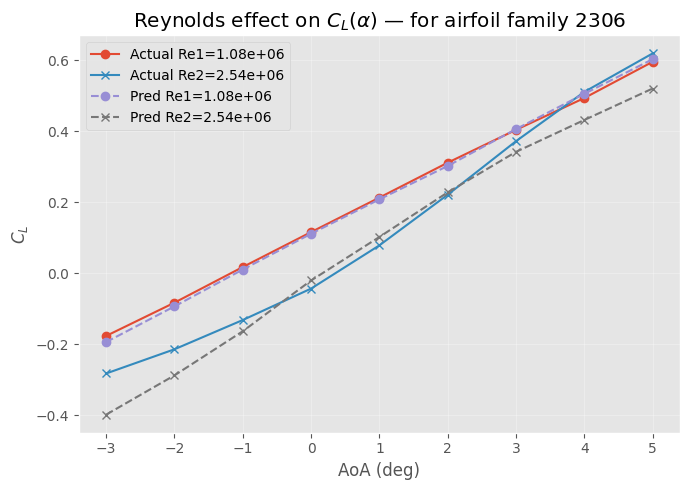

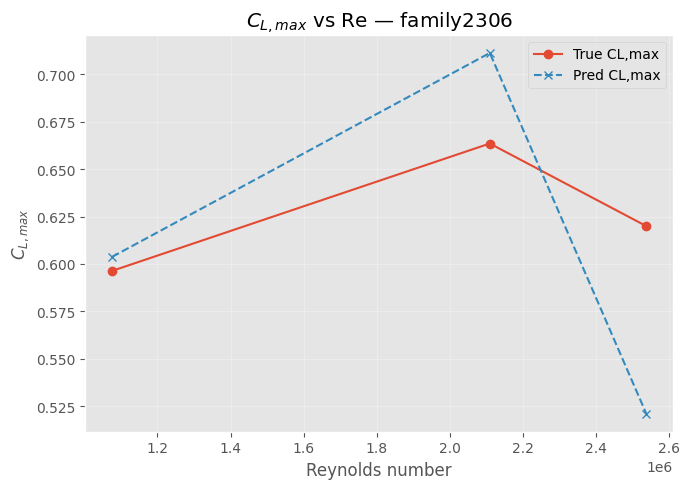

In [19]:
# -----------------------------------------------------------------
# TASK D.4 & D.5: REYNOLDS NUMBER SENSITIVITY STUDY
# -----------------------------------------------------------------
# Objective: Quantify how well the model captures the "Reynolds Effect"
# specifically how the lift curve and maximum lift (Cl_max) change as the Re increases

# FAM = "2306"
FAM = pick2AF[0]

# Safety: indices must align
assert (testA_df_scaled.index == testA_df.index).all(), "Scaled/unscaled Test-A indices do not match."

# -----------------------------
# Build a combined analysis dataframe for Test-A
#    with AoA in degrees, true Cl, and Bayes predictions
testA_an = testA_df_scaled.copy()
testA_an["AF_family"] = testA_df.loc[testA_an.index, "AF_family"].values
testA_an["AoA_deg"]   = testA_df.loc[testA_an.index, "AoA"].values
testA_an["Re_phys"]   = testA_df.loc[testA_an.index, "Re"].values       # unscaled Reynolds for plots
testA_an["Cl_true"]   = testA_df.loc[testA_an.index, target_col].values

# Predict with Bayes model for all Test-A rows
X_testA = testA_an[feature_cols].to_numpy(dtype=np.float64)
X_testA_t = pt.tensor(X_testA, dtype=pt.float64)

bayes_model.eval()
with pt.no_grad():
    # store predictions
    testA_an["Cl_pred"] = bayes_model(X_testA_t).detach().numpy().reshape(-1)

# Filter the dataframe on the chosen airfoil family
fam_df = testA_an[testA_an["AF_family"] == FAM].copy()
# print(f"Test-A rows for family {FAM}:", fam_df.shape[0])
# print("Unique Re (physical) in Test-A for this family :", np.sort(fam_df["Re_phys"].unique()))

# Choose two Reynolds numbers (lowest and highest)
uniqRe = np.sort(fam_df["Re_phys"].unique())
Re1, Re2 = uniqRe[0], uniqRe[-1]
# print(f"Selected Re for CL-alpha comparison: Re1= {Re1:.2e}, Re2= {Re2:.2e}")

# ---------------------------------------
#             Plot : CL vs AoA
# This plot compares the full lift sweeps for two different Re values.

def get_curve(df, Re_val):
    c = df[(df["Re_phys"] == Re_val)].sort_values("AoA_deg")
    return c
c1 = get_curve(fam_df, Re1)   # Low Re data
c2 = get_curve(fam_df, Re2)   # High Re data
plt.figure(figsize=(7,5))

# Actual curves
plt.plot(c1["AoA_deg"], c1["Cl_true"], marker="o", label=f"Actual Re1={Re1:.2e}")
plt.plot(c2["AoA_deg"], c2["Cl_true"], marker="x", label=f"Actual Re2={Re2:.2e}")

# Predicted curves
plt.plot(c1["AoA_deg"], c1["Cl_pred"], marker="o", linestyle="--", label=f"Pred Re1={Re1:.2e}")
plt.plot(c2["AoA_deg"], c2["Cl_pred"], marker="x", linestyle="--", label=f"Pred Re2={Re2:.2e}")

plt.xlabel("AoA (deg)") ; plt.ylabel("$C_L$")
plt.title(f"Reynolds effect on $C_L(\\alpha)$ — for airfoil family {FAM}")
plt.grid(alpha=0.3) ; plt.legend() ; plt.tight_layout()
# plt.savefig('results_plot/taskD4_Cl.png', dpi=600)
plt.show()


# ---------------------------------------------------------
#            Plot 2: CL_max vs Reynolds
# Maximum lift is a key performance metric. We check if the model
# correctly predicts that Cl_max generally increases with Reynolds number.

cl_max = fam_df.groupby('Re_phys')[['Cl_true', 'Cl_pred']].max().reset_index()

plt.figure(figsize=(7, 5))
plt.plot(cl_max['Re_phys'], cl_max['Cl_true'], 'o-', label='True CL,max')
plt.plot(cl_max['Re_phys'], cl_max['Cl_pred'], 'x--', label='Pred CL,max')
plt.xlabel('Reynolds number'); plt.ylabel('$C_{L,max}$')
plt.title(f'$C_{{L,max}}$ vs Re — family{FAM}')
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
# plt.savefig('results_plot/taskD4_Clmax.png', dpi=600)
plt.show()
